## Przewidywanie trendu kursu giełdowego

## Przewidywana jest wartość WIG w następnym dniu na podstawie wartości w dniach poprzednich

## Początkowa obróbka danych

In [1]:
def selectTimeRange(df, start_date, end_date):
    from datetime import datetime as dt
    
    start_date = dt.strptime(start_date, '%d.%m.%Y')
    end_date = dt.strptime(end_date, '%d.%m.%Y')
    
    low_idx = 0
    while dt.strptime( df['dates'][low_idx], '%d.%m.%Y') <= start_date:
        low_idx = low_idx + 1
    
    up_idx = df.index.stop - 1
    while dt.strptime( df['dates'][up_idx], '%d.%m.%Y') >= end_date:
        up_idx = up_idx - 1
        
    df = df[ low_idx:up_idx ]
    df.reindex( [ i for i in range(len(df)) ] )
    return df 

# Wczytaj dane i ustaw przedział czasowy
import pandas as pd

df_raw = pd.read_csv("data.csv")
# df = selectTimeRange(df_raw, '01.01.2018', '31.12.2023')
df = df_raw.copy()
df.head()

,dates,usd,pound,wig,euro
0,31.01.2013,3.0814,4.8857,46840.15,4.1944
1,01.02.2013,3.0498,4.7882,46945.58,4.1630
2,04.02.2013,3.0905,4.8666,46556.55,4.1761
3,05.02.2013,3.0747,4.8168,46674.78,4.1764
4,06.02.2013,3.0875,4.8347,46149.14,4.1752


## (Opcjonalne) Uśrednienie przebiegu

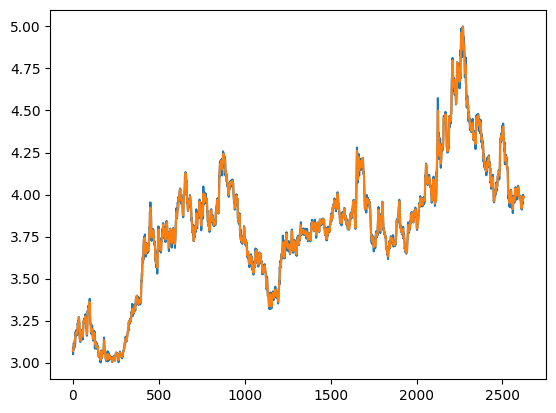

In [2]:
def median(values, kernel_size=3):
    result = [None]*len(values)
    for i in range(len(values)):
        new_val = 0
        for j in range( -int(kernel_size/2), int(kernel_size/2) + 1 ):
            if i + j < 0:
                new_val = new_val + values[0]
            elif i + j >= len(values):
                new_val = new_val + values[ len(values) - 1 ]
            else:
                new_val = new_val + values[i+j]
        new_val = new_val / kernel_size
        result[i] = new_val
    return result
                
df['usd'].plot()
import matplotlib.pyplot as plt

plt.plot( median(df['usd'], kernel_size=3) ) 

for col in df.columns[1:]:
    df[col] = median( df[col], kernel_size=3 )

## Pomocniczy dataframe ze względnymi zmianami

In [3]:
# TODO - poczyścić niepotrzebne
def absoluteChange( prizes ):
    result = [None]*( len(prizes) )
    result[0] = 0
    for i in range( 1, len(prizes) ):
        result[i] = prizes[i] - prizes[i-1]
    return result

def relativeChange( prizes ):
    result = [None]*( len(prizes) )
    result[0] = 0
    for i in range( 1, len(prizes) ):
        result[i] = prizes[i] / prizes[i-1]
    return result

def relativeAbsoluteChange( prizes ):
    result = [None]*( len(prizes) )
    result[0] = 0
    for i in range( 1, len(prizes) ):
        result[i] = prizes[i] / prizes[i-1] - 1
    return result

def dataChange( df, mode ):
    import pandas as pd
    
    cols = list( df.columns)
    temp_dict = { c:None for c in cols }
    for c in cols[1:]:
        if mode == 'absolute':
            temp_dict[c] = absoluteChange( df[c] )
        elif mode == 'relative':
            temp_dict[c] = relativeChange( df[c] )
        elif mode == 'relabs':
            temp_dict[c] = relativeAbsoluteChange( df[c] )
        else:
            return None
    temp_dict[ cols[0] ] = df[ cols[0] ]
    df_dt = pd.DataFrame(temp_dict)
    return df_dt

df_dt = dataChange( df, 'relabs' )
df_dt.head()

,dates,usd,pound,wig,euro
0,31.01.2013,0.000000,0.000000,0.000000,0.000000
1,01.02.2013,0.000988,-0.001312,-0.002017,-0.001458
2,04.02.2013,-0.000727,-0.004738,-0.001178,-0.001436
3,05.02.2013,0.004091,0.003213,-0.005682,0.000975
4,06.02.2013,0.002669,0.001481,-0.001628,-0.000495


## Usunięcie 5% outlierów 

In [4]:
def threeSigma(values):
    import statistics as stats
    
    stdev = stats.stdev(values)
    mean = stats.mean(values)
    result = []
    for i, x in enumerate(values):
        if abs( x - mean ) > 3*stdev:
            result.append([ i, x ])
    return result

def interQuartile(values, Q1_percentile = 25, Q3_percentile=75):
    import numpy as np
    Q1 = np.percentile(values, Q1_percentile, method='midpoint')
    Q3 = np.percentile(values, Q3_percentile, method='midpoint')
    IQR = Q3 - Q1
    upper = Q3+1.5*IQR
    lower = Q1-1.5*IQR

    result = []
    for i, x in enumerate(values):
        if x >= upper or x <= lower:
            result.append([ i, x ])
    return result

def kernelEstimation(values, method='gaussian', percentile=7):
    from sklearn.neighbors import KernelDensity
    import numpy as np

    values = np.array(values)
    values = values.reshape(-1, 1)
    kde = KernelDensity(kernel=method).fit(values)
    yvals = kde.score_samples(values) 
    outlier_inds = np.where(yvals < np.percentile(yvals, percentile))[0]
    return [ [i, values[i] ] for i in outlier_inds ]

def getOutliers(df, method, params=None):
    import pandas as pd
    
    res = None
    if method == '3sig':
        res = threeSigma(df[ df.columns[1] ] )
    if method == 'intquart':
        if params != None:
            res = interQuartile(df[ df.columns[1] ], params[0], params[1] )
        else:
            res = interQuartile(df[ df.columns[1] ])
    if method == 'kernel':
        if params != None:
            res = kernelEstimation(df[ df.columns[1] ], params[0], params[1] )
        else:
            res = kernelEstimation(df[ df.columns[1] ] )
    vals = [ r[1] for r in res ]
    idx = [ r[0] for r in res ]
    dates = df_dt['dates'][ idx ]
    return pd.DataFrame( { 'dates':dates, 'outliers':vals, 'reference_index':idx } )

0.9497142857142857


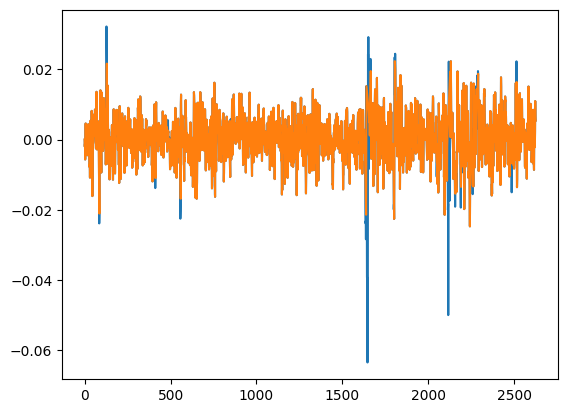

In [14]:
# Wspólne outliery dla całego zbioru - norma wektora N-wymiarowego + metdoa wykrywania outlierów
# liczę outliery,
from numpy.linalg import norm

if 'norm' in df_dt.columns:
    df_dt = df_dt.drop(columns='norm')
df_dt['norm'] = [ norm(v) for v in df_dt[ df_dt.columns[1:] ].values  ]

cols = ['dates', 'norm']
outliers = getOutliers( df_dt[cols][1:], 'kernel', ['gaussian', 5])
# outliers = getOutliers( df_dt[cols][1:], 'kernel', ['gaussian', 12])
# outliers = getOutliers( df_dt[cols][1:], 'intquart', [35, 64])
outliers.sort_values(
    by="outliers",
    key=lambda x: abs(1 - x),
    inplace=True,
    ascending=False)
outliers_history = [outliers]

# usuwam outliery z df_dt
df_dt_cleaned = df_dt[ df_dt.index.isin(outliers.index) == False ]
df_dt['wig'].plot()
df_dt_cleaned['wig'].plot()
print(len(df_dt_cleaned)/len(df_dt))

## Utworzenie zbioru treningowego i testowego

In [6]:
# Odłożenie części danych do późniejszej predykcji
future_len = 100

In [7]:
# Funkcja zależna od rodzju danych!!!
def prepareData(raw_data):
    x_cols = [ 'wig']
    y_cols = ['wig']
    X=[None]*( len(raw_data) - 1 )
    y=[None]*( len(raw_data)  - 1 )
    
    for i in range( len(raw_data)-1):
        xvals = []
        for col in x_cols:
            xvals.append( 100*raw_data[col].iloc[i] )
        X[i] = xvals
        
        yvals = []
        for col in y_cols:
            yvals.append( 100*raw_data[col].iloc[i + 1] )
        y[i] = yvals
    
    
    return {'X':X, 'y':y}

processed_data = prepareData(df_dt_cleaned[1:-future_len])

In [8]:
def splitDataToTrainAndTest( processed_data, trainingProportion):
    # trainingPorportion - stosunek podziału danych treningowych do testowych (0;1)
    
    data_len = len(processed_data['X'])
    
    X_train = processed_data['X'][:int(data_len*trainingProportion)]
    y_train = processed_data['y'][:int(data_len*trainingProportion)]
    X_val = processed_data['X'][int(data_len*trainingProportion):]
    y_val = processed_data['y'][int(data_len*trainingProportion):]
    
    return X_train, y_train, X_val, y_val

trainingProportion = 0.6
X_train, y_train, X_val, y_val = splitDataToTrainAndTest(processed_data, trainingProportion)

## Utworzenie modelu i trening

In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError, CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.optimizers import Adam 

n_input = 1
n_features = 1

model_stock = Sequential()

model_stock.add(InputLayer((n_input, n_features)))

model_stock.add(LSTM(300, return_sequences=True))
model_stock.add(Dropout(0.2))

model_stock.add(Flatten())
model_stock.add(Dense(1, activation="linear"))

model_stock.summary()

In [10]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 4 )
model_stock.compile(loss = MeanSquaredError(),
    optimizer=Adam(
        learning_rate=0.001
    ),
    metrics=BinaryCrossentropy()),
history = model_stock.fit(
    X_train, y_train,
    validation_data= (X_val, y_val),
    epochs = 100,
    callbacks=[early_stop],
)


Epoch 1/100
45/45 [==============================] - 1s 11ms/step - loss: 0.2261 - binary_crossentropy: -1.5716 - val_loss: 0.3140 - val_binary_crossentropy: -1.5701
Epoch 2/100
45/45 [==============================] - 0s 6ms/step - loss: 0.1732 - binary_crossentropy: -1.6871 - val_loss: 0.3064 - val_binary_crossentropy: -1.5928
Epoch 3/100
45/45 [==============================] - 0s 6ms/step - loss: 0.1694 - binary_crossentropy: -1.6577 - val_loss: 0.3043 - val_binary_crossentropy: -1.6026
Epoch 4/100
45/45 [==============================] - 0s 5ms/step - loss: 0.1689 - binary_crossentropy: -1.6732 - val_loss: 0.3049 - val_binary_crossentropy: -1.5959
Epoch 5/100
45/45 [==============================] - 0s 5ms/step - loss: 0.1688 - binary_crossentropy: -1.6897 - val_loss: 0.3052 - val_binary_crossentropy: -1.5900
Epoch 6/100
45/45 [==============================] - 0s 5ms/step - loss: 0.1684 - binary_crossentropy: -1.7020 - val_loss: 0.3050 - val_binary_crossentropy: -1.5973
Epoch 7/1

<Axes: >

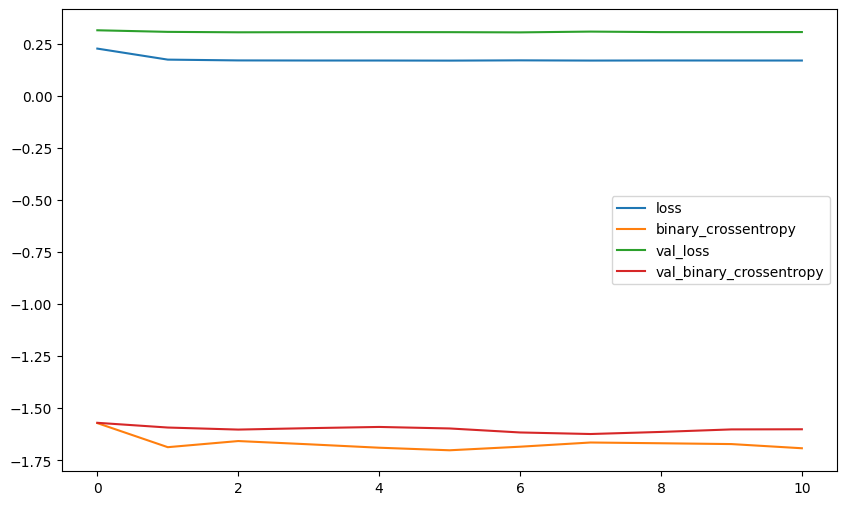

In [11]:
import pandas as pd

losses_df = pd.DataFrame(model_stock.history.history)
losses_df.plot(figsize = (10,6))

## Predykcja na danych treningowych i walidacyjnych

45/45 [==============================] - 0s 1ms/step


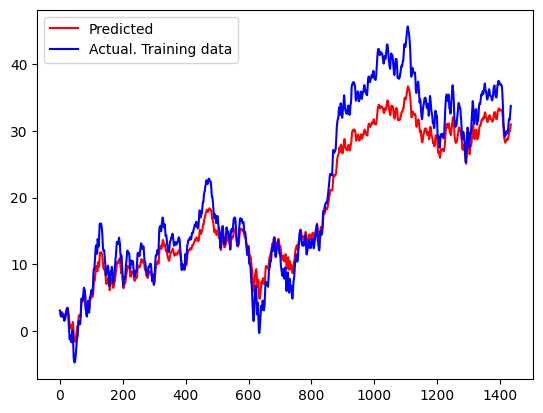

30/30 [==============================] - 0s 1ms/step


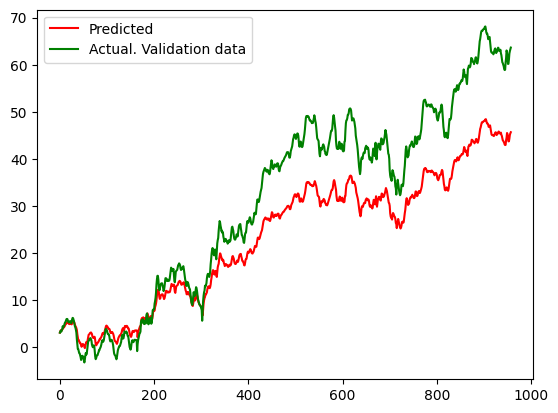

In [12]:
def integral(X, initial_state):
    result = [None]*(len(X)+1)
    result[0] = initial_state
    for i in range(1, len(result)):
        result[i] = result[i-1] + (lambda x: x[0] if type(x) == list else x )(X[i-1])
    return result

def integral2(X, initial_state):
    result = [None]*(len(X)+1)
    result[0] = initial_state
    for i in range(1, len(result)):
        result[i] = result[i-1] + (lambda x: x[0] if type(x) == list else x )(X[i-1]) * 4
    return result

initial_state = df['usd'][0]

from matplotlib import pyplot as plt

# predykcja - tylko training data
X_test = X_train
y_pred = model_stock.predict(X_test).flatten()
plt.plot( integral(y_pred, initial_state), 'r', label="Predicted" )
plt.plot( integral(y_train, initial_state), 'b', label="Actual. Training data")
plt.legend()
plt.show()

# predykcja - tylko validation data
X_test = X_val
y_pred = model_stock.predict(X_test).flatten()
plt.plot( integral(y_pred, initial_state), 'r', label="Predicted" )
plt.plot( integral( y_val, initial_state ), 'g', label="Actual. Validation data")
plt.legend()
plt.show()

## Predykcja na nowych danych

4/4 [==============================] - 0s 1ms/step


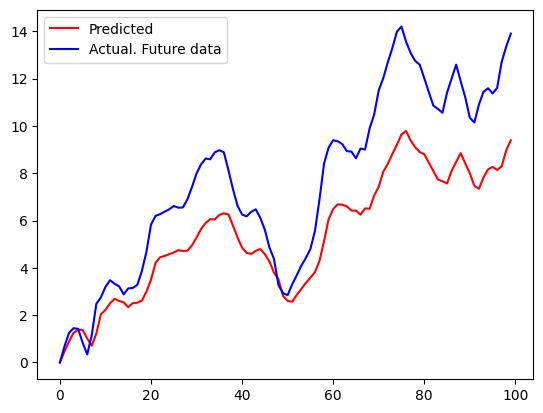

In [13]:
# predykcja - odłożona wcześniej porcja danych
future_data = prepareData(df_dt_cleaned[-future_len:])
f_training_proportion = 1
X_future, y_future, _, _ = splitDataToTrainAndTest(future_data, f_training_proportion)

y_pred = model_stock.predict(X_future).flatten()
initial_state = 0

plt.plot( integral(y_pred, initial_state), 'r', label="Predicted" )
plt.plot( integral(y_future, initial_state), 'b', label="Actual. Future data")
plt.legend()
plt.show()